In [ ]:
# CS 898 AW - Spring 2025
# Group 17
# Initial neural machine translation code for training
# Open-source LSTM & attnention based model
# Reference: https://paperswithcode.com/paper/effective-approaches-to-attention-based
# Reference: https://github.com/philipperemy/keras-attention
# Reused under Apache 2.0 License

Notes:
- The LSTM attention modules are global attention
- Only a fraction of the training data was usable due to Colab memory constraints
- The network is a general recreation of the original paper's architecture, not a one-for-one as their code was in MATLAB and used a few linked T4 GPUs

In [ ]:
# Install keras attention package
!pip install attention

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import AdditiveAttention
from attention import Attention
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import datasets
# WMT 2014 English-German dataset
train_df = pd.read_csv('/content/drive/MyDrive/School/CS 770 - ML/Group Project/WMT Data/wmt14_translate_de-en_train.csv', nrows=50000) # Reduced number of rows due to TPU & Colab memory constraints
validation_df = pd.read_csv('/content/drive/MyDrive/School/CS 770 - ML/Group Project/WMT Data/wmt14_translate_de-en_validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/School/CS 770 - ML/Group Project/WMT Data/wmt14_translate_de-en_test.csv')

In [ ]:
# Initialize the German tokenizer
tokenizer_de = Tokenizer()

# Fit the German tokenizer on the German sentences
tokenizer_de.fit_on_texts(validation_df['de'])

# Initialize the English tokenizer
tokenizer_en = Tokenizer()

# Fit the English tokenizer on the English sentences
tokenizer_en.fit_on_texts(validation_df['en'])

# Print the word indices
print("German word indices:", tokenizer_de.word_index)
print("English word indices:", tokenizer_en.word_index)

German word indices: {'die': 1, 'der': 2, 'und': 3, 'in': 4, 'das': 5, 'zu': 6, 'von': 7, 'den': 8, 'ist': 9, 'es': 10, 'mit': 11, 'dass': 12, 'nicht': 13, 'für': 14, 'im': 15, 'auf': 16, 'sie': 17, 'sich': 18, 'eine': 19, 'ein': 20, 'des': 21, 'er': 22, 'ich': 23, 'dem': 24, 'als': 25, 'sind': 26, 'auch': 27, 'wir': 28, 'an': 29, 'werden': 30, 'hat': 31, 'wie': 32, 'haben': 33, 'aber': 34, 'einer': 35, 'bei': 36, 'um': 37, 'aus': 38, 'wird': 39, 'einen': 40, 'oder': 41, 'einem': 42, 'nach': 43, 'man': 44, 'war': 45, 'diese': 46, 'am': 47, 'nur': 48, 'wurde': 49, 'über': 50, 'wenn': 51, 'noch': 52, 'vor': 53, 'so': 54, 'zur': 55, 'sein': 56, 'was': 57, 'habe': 58, 'gibt': 59, 'zum': 60, 'bis': 61, 'kann': 62, 'seine': 63, 'mehr': 64, 'dies': 65, 'sagt': 66, 'dieser': 67, 'keine': 68, 'ihre': 69, 'uns': 70, 'durch': 71, 'können': 72, 'jahren': 73, 'jahr': 74, 'dieses': 75, 'menschen': 76, 'wurden': 77, 'unter': 78, 'welt': 79, 'damit': 80, 'dann': 81, 'eines': 82, 'viele': 83, 'hatte': 

In [ ]:
print("--- Defining Encoder-Decoder Model with Attention ---")

max_len_de = 85
max_len_en = 81
num_encoder_tokens = 10000
num_decoder_tokens = len(tokenizer_en.word_index) + 1
latent_dim = 256

# === Encoder ===
encoder_inputs = keras.Input(shape=(max_len_de,), name='encoder_input')
encoder_embedding_layer = layers.Embedding(num_encoder_tokens, latent_dim, name='encoder_embedding')
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c] # Context vectors for the decoder

# === Decoder ===
decoder_inputs = keras.Input(shape=(max_len_en,), name='decoder_input')
decoder_embedding_layer = layers.Embedding(num_decoder_tokens, latent_dim, name='decoder_embedding') # Re-use or new layer is fine
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
# Use encoder states as initial state for the decoder
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# === Attention Mechanism ===
# --- Add these print lines for debugging ---
print("DEBUG (during model build): Decoder outputs shape:", decoder_outputs.shape, "dtype:", decoder_outputs.dtype)
print("DEBUG (during model build): Encoder outputs shape:", encoder_outputs.shape, "dtype:", encoder_outputs.dtype)

# Using AdditiveAttention explicitly
attention_layer = AdditiveAttention(name='attention_layer')
attention_layer_2 = AdditiveAttention(name='attention_layer_2')  # Second attention layer
#attention_layer_3 = AdditiveAttention(name='attention_layer_3')  # Third attention layer
# Query: Decoder outputs, Value: Encoder outputs (Key defaults to Value if not provided)
context_vector_1 = attention_layer([decoder_outputs, encoder_outputs]) ##edited

# Second attention layer (new)
context_vector_2 = attention_layer_2([decoder_outputs, encoder_outputs])

# Combine context vectors (new)
combined_context_vector = layers.Concatenate(axis=-1)([context_vector_1, context_vector_2, decoder_outputs])

# === Combine Attention Context and Decoder Output ===
decoder_combined_context = layers.Concatenate(axis=-1)([combined_context_vector, decoder_outputs]) #edited

# === Final Output Layer ===
# TimeDistributed applies the Dense layer to each time step
decoder_dense = layers.TimeDistributed(
    layers.Dense(num_decoder_tokens, activation='softmax'), name='output_dense'
)
decoder_final_outputs = decoder_dense(decoder_combined_context) # Use the combined context

# === Define and Compile Model ===
model = keras.Model([encoder_inputs, decoder_inputs], decoder_final_outputs, name='seq2seq_attention_model')

# Using sparse loss because targets are integers
from tensorflow.keras.optimizers import RMSprop
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Adam performed significantly better than RMSprop or SGD
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary ---")
model.summary()
print("---------------------\n")

--- Defining Encoder-Decoder Model with Attention ---
DEBUG (during model build): Decoder outputs shape: (None, 81, 256) dtype: float32
DEBUG (during model build): Encoder outputs shape: (None, 85, 256) dtype: float32

--- Model Summary ---


Model: "seq2seq_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 85)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, 81)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 85, 256)        │      2,560,000 │ encoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, 81, 256)        │      2,273,792 │ decoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 85, 256),      │        525,312 │ encoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 81, 256),      │        525,312 │ decoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 256)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 81, 256)        │            256 │ decoder_lstm[0][0],    │
│ (AdditiveAttention)       │                        │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_2         │ (None, 81, 256)        │            256 │ decoder_lstm[0][0],    │
│ (AdditiveAttention)       │                        │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 81, 768)        │              0 │ attention_layer[0][0], │
│                           │                        │                │ attention_layer_2[0][… │
│                           │                        │                │ decoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 81, 1024)       │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ decoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_dense              │ (None, 81, 8882)       │      9,104,050 │ concatenate_1[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,988,978 (57.18 MB)

 Trainable params: 14,988,978 (57.18 MB)

 Non-trainable params: 0 (0.00 B)

---------------------



In [ ]:
# Create encoder input sequences (German)
# Useful module for preprocessing input data across the three input dfs
def prepare_data(input_df):
  import tensorflow as tf
  from tensorflow.keras.preprocessing.sequence import pad_sequences
  from tensorflow.keras.utils import to_categorical

  df = input_df.copy()
  encoder_input_sequences_de = tokenizer_de.texts_to_sequences(df['de'])

  # Create decoder input sequences (English)
  decoder_input_sequences_en = tokenizer_en.texts_to_sequences(df['en'])

  # Calculate maximum sequence lengths
  max_length_de = max(len(s) for s in encoder_input_sequences_de)
  max_length_en = max(len(s) for s in decoder_input_sequences_en)

  # 1. Pad sequences
  encoder_input_sequences_de = pad_sequences(
      encoder_input_sequences_de, maxlen=max_length_de, padding="post"
  )
  decoder_input_sequences_en = pad_sequences(
      decoder_input_sequences_en, maxlen=max_length_en, padding="post"
  )

  # 2. Create decoder target data (shifted by one timestep)
  decoder_target_sequences_en = []
  for sequence in decoder_input_sequences_en:
    target_sequence = sequence[1:]  # Shift by one timestep
    padded_sequence = tf.concat([target_sequence, tf.constant([0], dtype=tf.int32)], axis=0)  # Append 0
    decoder_target_sequences_en.append(padded_sequence)
  decoder_target_sequences_en = pad_sequences(decoder_target_sequences_en, maxlen=max_length_en, padding='post')
  decoder_target_sequences_en = tf.convert_to_tensor(decoder_target_sequences_en)  # Convert to tensor, pad to max length

  # 3. One-hot encode target data
  # Ensure num_classes matches the output layer's vocabulary size
  num_decoder_tokens = len(tokenizer_en.word_index) + 1  # Update num_decoder_tokens
  decoder_target_sequences_en = to_categorical(
      decoder_target_sequences_en, num_classes=num_decoder_tokens  # Use updated num_decoder_tokens
  )

  # Print the shapes to verify
  print("Encoder input shape:", encoder_input_sequences_de.shape)
  print("Decoder input shape:", decoder_input_sequences_en.shape)
  print("Decoder target shape:", decoder_target_sequences_en.shape)

  return encoder_input_sequences_de, decoder_input_sequences_en, decoder_target_sequences_en

In [ ]:
# Prepare hyperparameter tuning data using prepare_data and validation dataset
encoder_input_sequences_de, decoder_input_sequences_en, decoder_target_sequences_en = prepare_data(validation_df)

import pickle
# Save the German tokenizer
with open('tokenizer_de.pickle', 'wb') as handle:
    pickle.dump(tokenizer_de, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the English tokenizer
with open('tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

Encoder input shape: (3000, 85)
Decoder input shape: (3000, 81)
Decoder target shape: (3000, 81, 8882)


In [1]:
# Load saved tokenizers, if available
import pickle
with open('tokenizer_de.pickle', 'rb') as handle:
    tokenizer_de = pickle.load(handle)

with open('tokenizer_en.pickle', 'rb') as handle:
    tokenizer_en = pickle.load(handle)

# Apply to encoder and decoder sequence variables
encoder_input_sequences_de, decoder_input_sequences_en, decoder_target_sequences_en = prepare_data(validation_df)

FileNotFoundError: [Errno 2] No such file or directory: 'tokenizer_de.pickle'

In [ ]:
# Train the en-de model on validation dataset for hyperparameter tuning
val_model = model.fit(
  x=[encoder_input_sequences_de, decoder_input_sequences_en],
  y=decoder_target_sequences_en,
  batch_size=32,
  epochs=20,
  validation_split=0
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7381 - loss: 3.1396
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 208ms/step - accuracy: 0.7876 - loss: 1.6086
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.7865 - loss: 1.5959
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.7890 - loss: 1.5642
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.7939 - loss: 1.5108
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.8014 - loss: 1.4205
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.8021 - loss: 1.3686
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.8047 - loss: 1.2912
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.8133 - loss: 1.1661
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.8135 - loss: 1.0986
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.8273 - loss: 0.9679
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
# Save model
model.save('g17_nmt_lstm_val_df.keras')

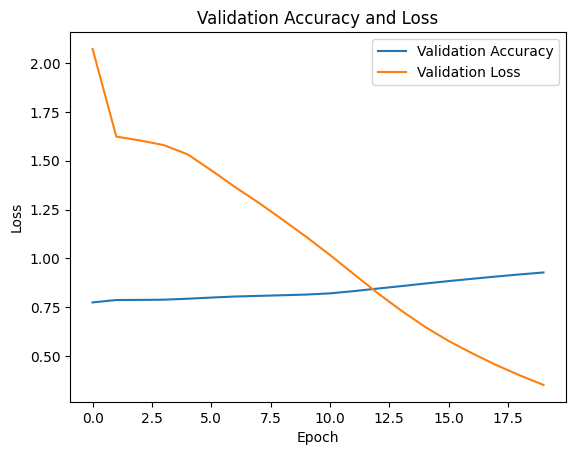

In [ ]:
# Plot Loss and Accuracy
plt.title('Validation Accuracy and Loss')
plt.plot(val_model.history['accuracy'], label='Validation Accuracy')
plt.plot(val_model.history['loss'], label='Validation Loss')
#plt.plot(val_model.history['val_loss'], label='Validation Loss') # Not needed here since we're already using a validation set
#plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Evaluate model on test dataset
model.evaluate(
  x=[encoder_input_sequences_de, decoder_input_sequences_en],
  y=decoder_target_sequences_en
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9417 - loss: 0.2881


[0.28838974237442017, 0.9420332312583923]

In [ ]:
# Load saved model if necessary
model = load_model('g17_nmt_lstm_val_df.keras')

In [ ]:
# BLEU Scoring Package
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.6 MB/s eta 0:00:00
